# Marmousi RTM

In [49]:
from devito import *
from examples.seismic import Model, AcquisitionGeometry, PointSource, RickerSource, TimeAxis
from examples.seismic import plot_velocity, plot_shotrecord, plot_perturbation, plot_image
from examples.seismic.acoustic import AcousticWaveSolver
from extra_plotting import *
from variable_density import VariableDensityAcousticWaveSolver

import numpy as np
from datasets.marmousi import load_marmousi_dataset

import gc

configuration['log-level'] = 'WARNING'

## Load the model and define parameters

In [50]:
# Model creation function

def create_model(model: Model = None):
    if model:
        return Model(
            vp=model.vp.data[model.nbl:-model.nbl, model.nbl:-model.nbl],
            origin=model.origin, 
            shape=model.shape, 
            spacing=model.spacing, 
            space_order=model.space_order,
            grid=model.grid,
            nbl=model.nbl,
            b=model.b.data[model.nbl:-model.nbl, model.nbl:-model.nbl],
            bcs='damp'
        )
    else:
        marmousi_dataset = load_marmousi_dataset()
        return marmousi_dataset.get_model(True)

In [51]:
# Parameters

filter_sigma = (6, 6)
nshots = 151
# nreceivers = 101
t0 = 0.
tn = 4500.  # Simulation last 1 second (1000 ms)
f0 = 0.0065  # Source peak frequency is 10Hz (0.010 kHz)

# shape = (101, 101)  # Number of grid point (nx, nz)
# spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
# origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# space_order = 4
time_order = 2
# nbl = 20

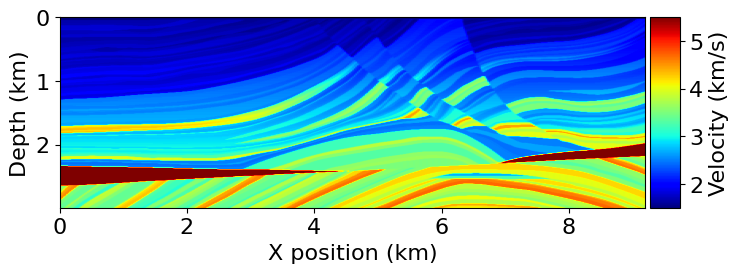

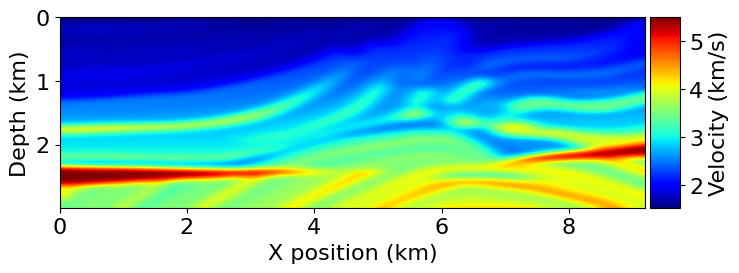

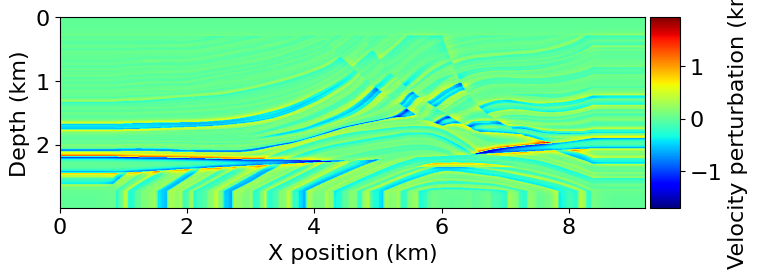

In [52]:
#

model = create_model()
model0 = create_model(model)
gaussian_smooth(model0.vp, sigma=filter_sigma)
# gaussian_smooth(model0.b.data, sigma=filter_sigma)


plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

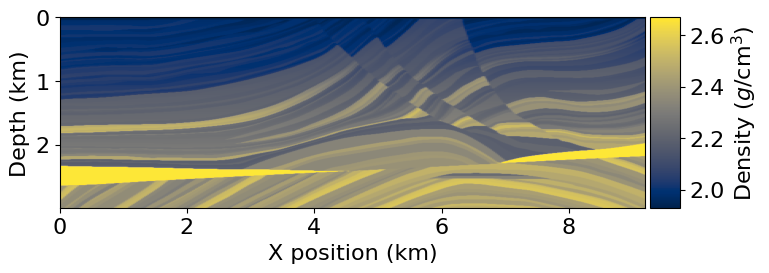

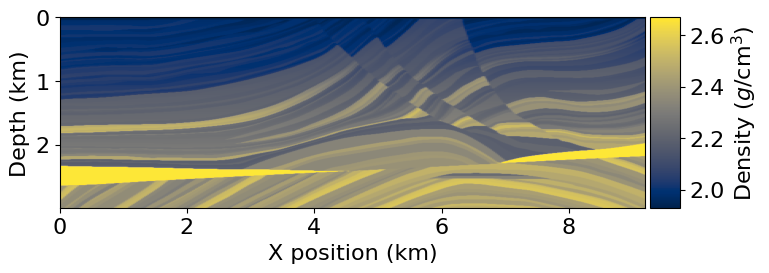

In [53]:
plot_density(model)
plot_density(model0)

## Plot shot record of each model

### Create the acquisition geometry

In [54]:
# Define source
time_range = TimeAxis(start=t0, stop=tn, step=model.critical_dt)

src_type = 'Ricker'
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = 0.5 * np.array(model.domain_size)
src_coordinates[0, -1] = 20

src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = 0.5 * np.array(model.domain_size)
src.coordinates.data[0, -1] = 1.

In [55]:
# Define receivers
nreceivers = model.shape[0]
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 1.

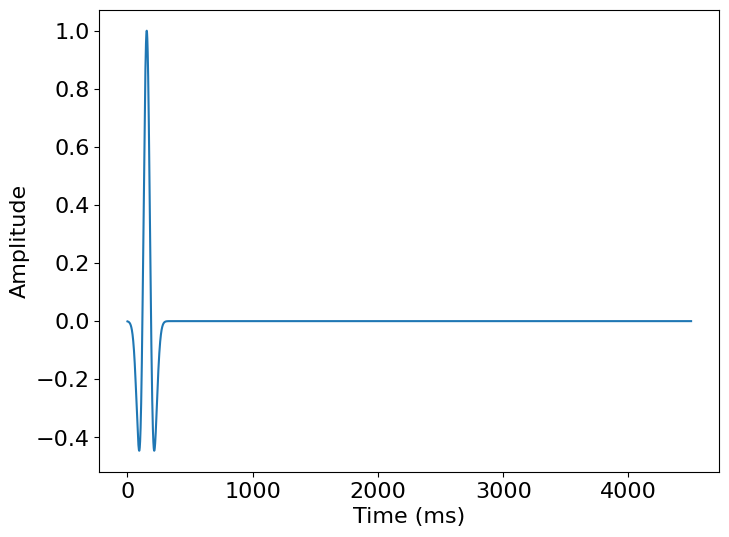

In [56]:
# Define geometry
geometry = AcquisitionGeometry(model, rec_coordinates, src.coordinates.data, t0, tn, f0=f0, src_type=src_type)
geometry.src.show()

### Generate and plot shot record data

In [57]:
# Create solver
solver = VariableDensityAcousticWaveSolver(model, geometry, space_order = model.space_order)
# solver = AcousticWaveSolver(model, geometry, space_order = model.space_order)

In [58]:
# Generate shot record
true_d, _, _ = solver.forward(vp = model.vp)
smooth_d, _, _ = solver.forward(vp = model0.vp)

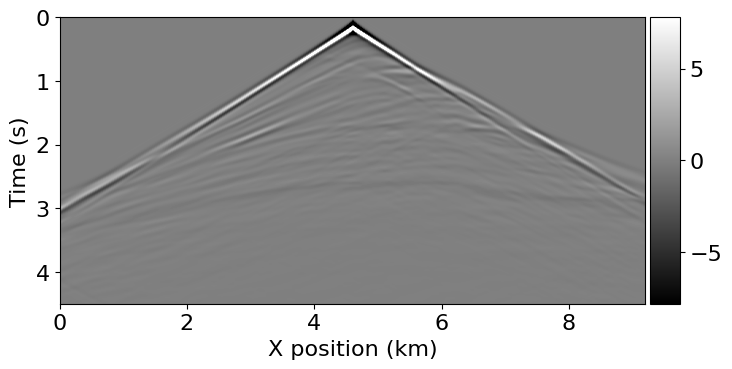

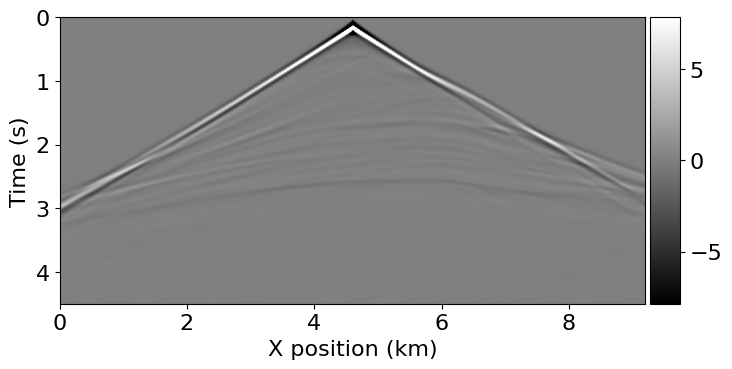

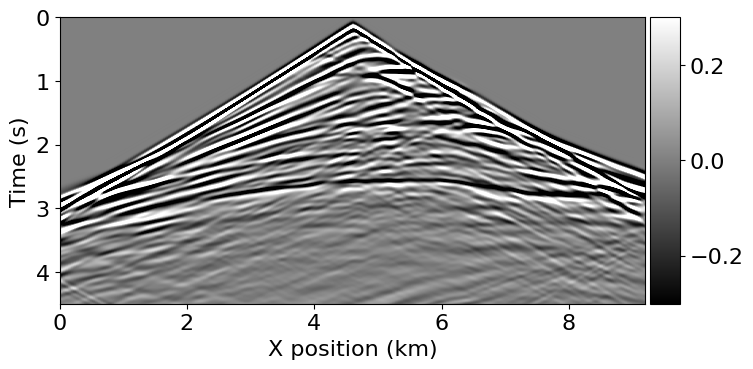

In [59]:
# Plot shot record

plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

## Imaging

In [60]:
# Define the image operator
time_order = 2
def ImagingOperator(model: Model, image: Function, geometry: AcquisitionGeometry):
    v = TimeFunction( # Ajoint field
        name='v', grid=model.grid, time_order = 2, space_order = model.space_order
    )
    u = TimeFunction( # Forward field
        name='u', grid=model.grid, time_order = 2, space_order = model.space_order, save = geometry.nt
    )

    # Adjoint wave equation
    kappa = 1/(model.m * model.b)
    eqn = v.dt2 - kappa * div(model.b * grad(v, shift=0.5), shift=-0.5) + model.damp * v.dt.T
    # eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T  # Temp

    stencil = Eq(v.backward, solve(eqn, v.backward))

    dt = model.critical_dt

    # Residual injection
    residual = PointSource(
        name = 'residual',
        grid = model.grid,
        time_range=geometry.time_axis,
        coordinates = geometry.rec_positions
    )

    res_term = residual.inject(field = v.backward, expr = residual * dt**2/model.m)

    # Image condition
    image_update = Eq(image, image + u*v)

    return Operator([stencil] + res_term + [image_update], subs=model.spacing_map)
    


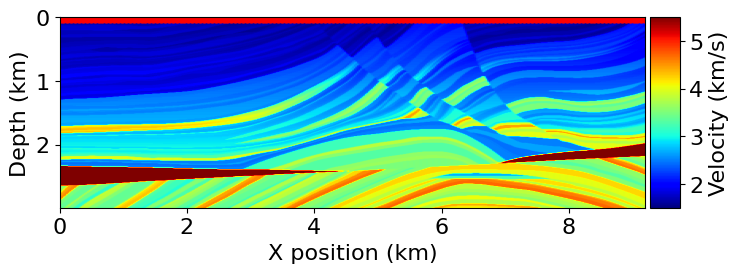

In [61]:
# Define source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0, model.domain_size[0], num = nshots)
source_locations[:, 1] = 30

plot_velocity(model, source=source_locations)

In [62]:
# Imaging loop

image = Function(name = 'image', grid = model.grid)
op = ImagingOperator(model, image, geometry)

for i in range(nshots):
    if i % 5 == 0:
        print(f'Imaging source {i + 1} out of {nshots}')

    geometry.src_positions[0, :] = source_locations[i, :]

    true_d, _, _ = solver.forward(vp = model.vp)
    smooth_d, u0, _ = solver.forward(vp = model0.vp, save = True)
    # smooth_d, u0, _ = solver.forward(vp = model0.vp)

    v = TimeFunction(name = 'v', grid = model.grid, time_order = 2, space_order = model.space_order)
    
    residual = smooth_d.data - true_d.data
    del true_d, smooth_d, _
    op(u=u0, v=v, vp=model0.vp, b=model0.b, dt=model0.critical_dt, residual=residual)
    # op(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, residual=residual)
    del u0, v, residual
    gc.collect()


Imaging source 1 out of 151


KeyboardInterrupt: 

Image


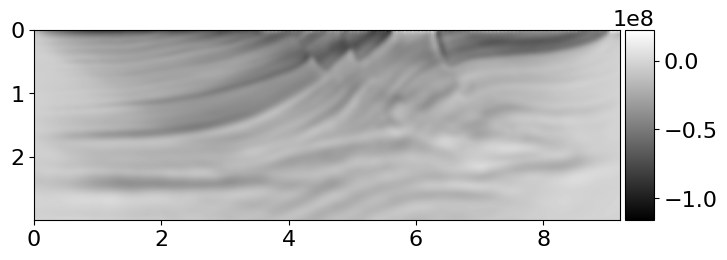

In [ ]:
slices = (slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
print('Image')
plot_image2(image.data[slices], model)

First derivative along z


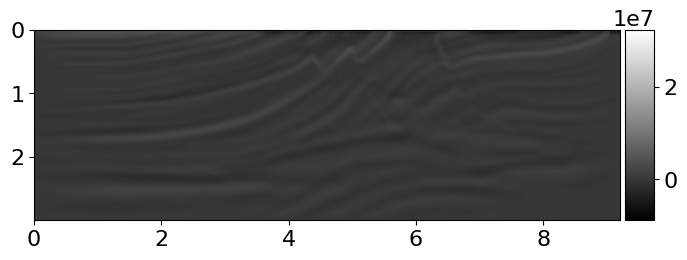

In [ ]:
print('First derivative along z')
plot_image2(np.diff(image.data[slices], axis=1), model)
# slices

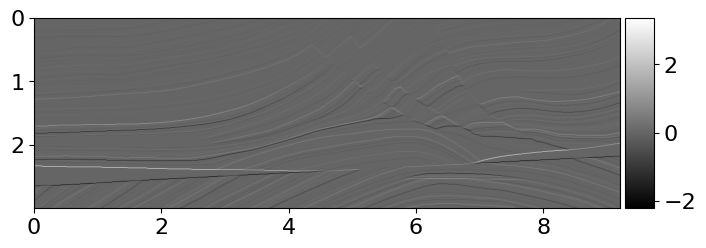

In [ ]:
plot_image2(np.diff(model.vp.data[slices], axis=1), model)